In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.pyplot as plt
from implementations import *
import os
import csv
from helpers import *

In [95]:
DATA_FOLDER = 'data/'

In [96]:
try:
    with open(DATA_FOLDER + 'x_train.pickle', 'rb') as f:
        x_train = pickle.load(f)
    with open(DATA_FOLDER + 'x_test.pickle', 'rb') as f:
        x_test = pickle.load(f)
    with open(DATA_FOLDER + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(DATA_FOLDER + 'test_ids.pickle', 'rb') as f:
        test_ids = pickle.load(f)
except:
    x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATA_FOLDER, sub_sample=False)

    names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
    names = np.delete(names, 0)
    names_map = {}
    for i in range(len(names)):
        names_map[names[i]] = i

    with open(DATA_FOLDER + 'x_train.pickle', 'wb') as f:
        pickle.dump(x_train, f)

    with open(DATA_FOLDER + 'x_test.pickle', 'wb') as f:
        pickle.dump(x_test, f)

    with open(DATA_FOLDER + 'y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f)

    with open(DATA_FOLDER + 'test_ids.pickle', 'wb') as f:
        pickle.dump(test_ids, f)

In [97]:
y_train = np.where(y_train == -1, 0, y_train)

In [98]:
x_tr = x_train.copy()
y_tr = y_train.copy()

# Pre-processing

In [99]:
#Converting the weights to kg, and asigning lacking answers to NaN
array = x_tr[:, names_map["WEIGHT2"]]
pounds_indices  = np.where(((array >= 50)*(array <= 999))==True)
kg_indices      = np.where(((array >= 9000)*(array <= 9998))==True)
none_indices    = np.where(((array == 7777) + (array == 9998))==True)

x_tr[:, names_map["WEIGHT2"]][pounds_indices] = 0.453592 * x_tr[:, names_map["WEIGHT2"]][pounds_indices]
x_tr[:, names_map["WEIGHT2"]][kg_indices] = x_tr[:, names_map["WEIGHT2"]][kg_indices]%9000
x_tr[:, names_map["WEIGHT2"]][none_indices] = np.nan

In [100]:
#converting the height to meters, and asigning lacking answers to NaN
array = x_tr[:, names_map["HEIGHT3"]]
imperial_indices    = np.where(((array >= 200)*(array <= 711))==True)
cm_indices          = np.where(((array >= 9000)*(array <= 9998))==True)
none_indices        = np.where((array == 9998)==True)

x_tr[:, names_map["HEIGHT3"]][imperial_indices] = 0.3048 * x_tr[:, names_map["HEIGHT3"]][imperial_indices]//100 + 0.0254 * x_tr[:, names_map["HEIGHT3"]][imperial_indices]%100
x_tr[:, names_map["HEIGHT3"]][cm_indices] = x_tr[:, names_map["HEIGHT3"]][cm_indices]%9000
x_tr[:, names_map["HEIGHT3"]][none_indices] = np.nan

In [101]:
#converting FLSHTMY2 to months, and asigning lacking answers to NaN
array = x_tr[:, names_map["FLSHTMY2"]]
none_indices = np.where(((array == 777777) + (array == 999999))==True)
days_indices = np.where(((array >= 12014)*(array <= 122015))==True)

x_tr[:, names_map["FLSHTMY2"]][none_indices] = np.nan
x_tr[:, names_map["FLSHTMY2"]][days_indices] = x_tr[:, names_map["FLSHTMY2"]][days_indices]//10000 + 12*x_tr[:, names_map["FLSHTMY2"]][days_indices]%10000

In [102]:
#define a few functions used to clean and scale the data properly
def frequency_scaler(df, col):
    
    times_per_day   = np.where(((df[:, names_map[col]]>=101)*(df[:, names_map[col]]<=199))==True)
    times_per_week  = np.where(((df[:, names_map[col]]>=201)*(df[:, names_map[col]]<=299))==True)
    times_per_month = np.where(((df[:, names_map[col]]>=301)*(df[:, names_map[col]]<=399))==True)
    none_indices    = np.where(((df[:, names_map[col]] == 777) + (df[:, names_map[col]] == 999))==True)

    df[:, names_map[col]][times_per_day]                = df[:, names_map[col]][times_per_day]%100
    df[:, names_map[col]][times_per_week]               = (df[:, names_map[col]][times_per_week]%200)/7
    df[:, names_map[col]][times_per_month]              = (df[:, names_map[col]][times_per_month]%300)/30
    df[:, names_map[col]][df[:, names_map[col]]==300]   = 1/30
    df[:, names_map[col]][df[:, names_map[col]]==555]   = 0
    df[:, names_map[col]][none_indices]                 = np.nan

def weekly_frequency_scaler(df, col):
    times_per_week  = np.where(((df[:, names_map[col]]>=101)*(df[:, names_map[col]]<=199))==True)
    times_per_month = np.where(((df[:, names_map[col]]>=201)*(df[:, names_map[col]]<=299))==True)
    none_indices    = np.where(((df[:, names_map[col]] == 777) + (df[:, names_map[col]] == 999))==True)

    df[:, names_map[col]][times_per_week]                   = (df[:, names_map[col]][times_per_week]%100)/7
    df[:, names_map[col]][times_per_month]                  = (df[:, names_map[col]][times_per_month]%200)/30
    df[:, names_map[col]][df[:, names_map[col]]==888]       = 0
    df[:, names_map[col]][none_indices]                     = np.nan

def hours_to_minutes(df, col):
    hour_indices    = np.where(( (df[:, names_map[col]]>=1)*(df[:, names_map[col]]<=759) + (df[:, names_map[col]]>=800)*(df[:, names_map[col]]<=959))==True)
    none_indices    = np.where(((df[:, names_map[col]]==777) + (df[:, names_map[col]]==999))==True)
    
    df[:, names_map[col]][hour_indices] = 60*df[:, names_map[col]][hour_indices]//100 + df[:, names_map[col]][hour_indices]%100                                                 
    df[:, names_map[col]][none_indices] = np.nan

In [103]:
#fix the frequency scales of the following columns
frequency_scaler(x_tr, "FRUITJU1")
frequency_scaler(x_tr, "FRUIT1")
frequency_scaler(x_tr, "FVBEANS")
frequency_scaler(x_tr, "FVGREEN")
frequency_scaler(x_tr, "FVORANG")
frequency_scaler(x_tr, "VEGETAB1")

hours_to_minutes(x_tr, "EXERHMM1")
hours_to_minutes(x_tr, "EXERHMM2")

weekly_frequency_scaler(x_tr, "ALCDAY5")
weekly_frequency_scaler(x_tr, "EXEROFT1")
weekly_frequency_scaler(x_tr, "EXEROFT2")
weekly_frequency_scaler(x_tr, "STRENGTH")

In [104]:
#Transformation hashmap
dico_transfos={"GENHLTH":{7:np.nan,8:np.nan,9:np.nan},"POORHLTH":{88:0,77:np.nan,99:np.nan},"HLTHPLN1":{7:np.nan,9:np.nan},"CHECKUP1":{8:15,7:np.nan,9:np.nan},
               "BPMEDS":{7:np.nan,9:np.nan}, "TOLDHI2":{7:np.nan,9:np.nan}, "PHYSHLTH":{88:0,77:np.nan,99:np.nan},
               "MENTHLTH":{88:0,77:np.nan,99:np.nan}, "CVDSTRK3":{7:np.nan, 9:np.nan}, "HLTHPLN1":{9:np.nan}, "CHCOCNCR":{7:np.nan, 9:np.nan},
               "HAVARTH3":{7:np.nan, 9:np.nan}, "CHCKIDNY":{7:np.nan, 9:np.nan}, "DIABETE3":{7:np.nan, 9:np.nan}, "CHCCOPD1":{7:np.nan, 9:np.nan},
               "ASTHMA3":{7:np.nan, 9:np.nan}, "ASTHNOW":{7:np.nan, 9:np.nan}, "CHCSCNCR":{7:np.nan, 9:np.nan}, "ADDEPEV2":{7:np.nan, 9:np.nan},
               "DIABAGE2":{98:np.nan, 99:np.nan}, "EDUCA":{9:np.nan}, "INCOME2":{77:np.nan, 99:np.nan}, "QLACTLM2":{7:np.nan, 9:np.nan},
               "USEEQUIP":{7:np.nan, 9:np.nan}, "BLIND":{7:np.nan, 9:np.nan}, "DECIDE":{7:np.nan, 9:np.nan}, "DIFFWALK":{7:np.nan, 9:np.nan},
               "DIFFDRES":{7:np.nan, 9:np.nan}, "DIFFALON":{7:np.nan, 9:np.nan}, "SMOKE100":{7:np.nan, 9:np.nan}, "SMOKDAY2":{7:np.nan, 9:np.nan},
               "USENOW3":{7:np.nan, 9:np.nan}, "AVEDRNK2":{77:np.nan, 99:np.nan}, "DRNK3GE5":{77:np.nan, 88:np.nan, 99:np.nan}, "MAXDRNKS":{77:np.nan, 99:np.nan},
               "EXERANY2":{7:np.nan, 9:np.nan}, "EXERHMM1":{777:np.nan, 999:np.nan}, "SEATBELT":{7:np.nan, 8:np.nan, 9:np.nan}, "PNEUVAC3":{7:np.nan, 9:np.nan},
               "ARTHDIS2":{7:np.nan, 9:np.nan}, "ARTHSOCL":{7:np.nan, 9:np.nan}, "JOINPAIN":{77:np.nan, 99:np.nan}, "ARTHEDU":{7:np.nan, 9:np.nan}, "FLUSHOT6":{7:np.nan, 9:np.nan},
               "DOCTDIAB":{88:0, 77:np.nan, 99:np.nan}, "DIABEYE":{7:np.nan, 9:np.nan}, "CRGVMST2":{7:np.nan, 9:np.nan}, "VIDFCLT2":{7:np.nan}, "VIREDIF3":{7:np.nan},
               "VICTRCT4":{7:np.nan}, "VIGLUMA2":{7:np.nan}, "VIMACDG2":{7:np.nan}, "CIMEMLOS":{7:np.nan, 9:np.nan}, "CDSOCIAL":{7:np.nan, 9:np.nan}, "DRADVISE":{7:np.nan, 9:np.nan},
               "ASTHMAGE":{97:6, 98:np.nan, 99:np.nan}, "ASERVIST":{88:0}, "CVDASPRN":{7:np.nan, 9:np.nan}, "RDUCHART":{7:np.nan, 9:np.nan}, "ARTHEXER":{7:2, 9:2},
               "HPVADVC2":{7:np.nan, 9:np.nan}, "HPVADSHT":{77:np.nan, 99:np.nan}, "PCPSARE1":{7:np.nan, 9:np.nan}, "MISTMNT":{7:np.nan, 9:np.nan},
               "_CHISPNC":{9:np.nan}, "_RFCHOL":{9:np.nan}, "_LTASTH1":{9:1}, "_CASTHM1":{9:0}, "_ASTHMS1":{9:3}, "_HISPANC":{9:2}, "_AGEG5YR":{14:np.nan}, "_CHLDCNT":{9:np.nan},
               "_EDUCAG":{9:np.nan}, "_INCOMG":{9:np.nan}, "_SMOKER3":{9:4}, "_RFSMOK3":{9:1}, "DRNKANY5":{9:1, 7:1}, "DROCDY3_":{900:np.nan},
               "_TOTINDA":{9:np.nan}, "_LMTSCL1":{9:np.nan}, "_RFSEAT2":{9:0}, "_PASTRNG":{9:2}, "_PACAT1":{9:2}, "STRFREQ_":{99000:np.nan}
               }

In [125]:
x_tr_temp=x_tr.copy()
for col in dico_transfos:
    for key in dico_transfos[col].keys():
        key_indices = np.where(x_tr_temp[:, names_map[col]]==key)
        x_tr_temp[:, names_map[col]][key_indices]=dico_transfos[col][key]

In [ ]:
#function to NaN in a column of a pandas dataframe
def replace_nan(dataframe, column, value):
    nan_indices = np.where(np.isnan(dataframe[:, names_map[column]]))
    dataframe[:, names_map[column]][nan_indices] = value

In [141]:
x_tr[:, names_map["CRGVMST2"]].mean()

nan

In [142]:
counts = np.bincount(x_tr[:, names_map["CRGVMST2"]])

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [158]:
np.isnan(x_tr[:, names_map["CRGVMST2"]]).astype(int).sum()

310450

In [175]:
#define the means we will use to replace the NaN
POORHLTH_mean   = x_tr_temp[:, names_map["POORHLTH"]].mean()
PHYSHLTH_mean   = x_tr_temp[:, names_map["PHYSHLTH"]].mean()
MENTHLTH_mean   = x_tr_temp[:, names_map["MENTHLTH"]].mean()
WEIGHT2_mean    = x_tr_temp[:, names_map["WEIGHT2"]].mean()
DIABAGE2_mean   = x_tr_temp[:, names_map["DIABAGE2"]].mean()
WEIGHT2_mean    = x_tr_temp[:, names_map["WEIGHT2"]].mean()
HEIGHT3_mean    = x_tr_temp[:, names_map["HEIGHT3"]].mean()
FRUITJU1_mean   = x_tr_temp[:, names_map["FRUITJU1"]].mean()
FRUIT1_mean     = x_tr_temp[:, names_map["FRUIT1"]].mean()
FVBEANS_mean    = x_tr_temp[:, names_map["FVBEANS"]].mean()
FVGREEN_mean    = x_tr_temp[:, names_map["FVGREEN"]].mean()
FVORANG_mean    = x_tr_temp[:, names_map["FVORANG"]].mean()
VEGETAB1_mean   = x_tr_temp[:, names_map["VEGETAB1"]].mean()
EXERHMM1_mean   = x_tr_temp[:, names_map["EXERHMM1"]].mean()
FLSHTMY2_mean   = x_tr_temp[:, names_map["FLSHTMY2"]].mean()
FTJUDA1__mean   = x_tr_temp[:, names_map["FTJUDA1_"]].mean()
FRUTDA1__mean   = x_tr_temp[:, names_map["FRUTDA1_"]].mean()
BEANDAY__mean   = x_tr_temp[:, names_map["BEANDAY_"]].mean()
GRENDAY__mean   = x_tr_temp[:, names_map["GRENDAY_"]].mean()
ORNGDAY__mean   = x_tr_temp[:, names_map["ORNGDAY_"]].mean()
VEGEDA1__mean   = x_tr_temp[:, names_map["VEGEDA1_"]].mean()
STRFREQ__mean   = x_tr_temp[:, names_map["STRFREQ_"]].mean()

CRGVMST2_value    = x_tr[:, names_map["CRGVMST2"]].value_counts().index[0]
VICTRCT4_value    = x_tr[:, names_map["VICTRCT4"]].value_counts().index[0]
ARTHEXER_value    = 2
HPVADSHT_value    = 0
PCPSARE1_value    = 2

#define the medians we will use to replace the NaN
GENHLTH_median  = x_tr_temp[:, names_map["GENHLTH"]].median()
HLTHPLN1_median = x_tr_temp[:, names_map["HLTHPLN1"]].median()
CHECKUP1_median = x_tr_temp[:, names_map["CHECKUP1"]].median()
BPMEDS_median   = x_tr_temp[:, names_map["BPMEDS"]].median()
TOLDHI2_median  = x_tr_temp[:, names_map["TOLDHI2"]].median()
CVDSTRK3_median = x_tr_temp[:, names_map["CVDSTRK3"]].median()
CHCKIDNY_median = x_tr_temp[:, names_map["CHCKIDNY"]].median()
CHCOCNCR_median = x_tr_temp[:, names_map["CHCOCNCR"]].median()
HAVARTH3_median = x_tr_temp[:, names_map["HAVARTH3"]].median()
DIABETE3_median = x_tr_temp[:, names_map["DIABETE3"]].median()
CHCCOPD1_median = x_tr_temp[:, names_map["CHCCOPD1"]].median()
ASTHMA3_median  = x_tr_temp[:, names_map["ASTHMA3"]].median()
ASTHNOW_median  = x_tr_temp[:, names_map["ASTHNOW"]].median()
CHCSCNCR_median = x_tr_temp[:, names_map["CHCSCNCR"]].median()
ADDEPEV2_median = x_tr_temp[:, names_map["ADDEPEV2"]].median()
EDUCA_median    = x_tr_temp[:, names_map["EDUCA"]].median()
INCOME2_median  = x_tr_temp[:, names_map["INCOME2"]].median()
QLACTLM2_median = x_tr_temp[:, names_map["QLACTLM2"]].median()
USEEQUIP_median = x_tr_temp[:, names_map["USEEQUIP"]].median()
BLIND_median    = x_tr_temp[:, names_map["BLIND"]].median()
DECIDE_median   = x_tr_temp[:, names_map["DECIDE"]].median()
DIFFWALK_median = x_tr_temp[:, names_map["DIFFWALK"]].median()
DIFFDRES_median = x_tr_temp[:, names_map["DIFFDRES"]].median()
DIFFALON_median = x_tr_temp[:, names_map["DIFFALON"]].median()
SMOKE100_median = x_tr_temp[:, names_map["SMOKE100"]].median()
SMOKDAY2_median = x_tr_temp[:, names_map["SMOKDAY2"]].median()
USENOW3_median  = x_tr_temp[:, names_map["USENOW3"]].median()
ALCDAY5_median  = x_tr_temp[:, names_map["ALCDAY5"]].median()
AVEDRNK2_median = x_tr_temp[:, names_map["AVEDRNK2"]].median()
DRNK3GE5_median = x_tr_temp[:, names_map["DRNK3GE5"]].median()
MAXDRNKS_median = x_tr_temp[:, names_map["MAXDRNKS"]].median()
EXERANY2_median = x_tr_temp[:, names_col["EXERANY2"]].median()
SEATBELT_median = x_tr_temp[:, names_col["SEATBELT"]].median()
PNEUVAC3_median = x_tr_temp[:, names_col["PNEUVAC3"]].median()
VIDFCLT2_median = x_tr_temp[:, names_col["VIDFCLT2"]].median()
_BMI5_median    = x_tr_temp[:, names_col["_BMI5"]].median()
MSCODE_median   = x_tr_temp[:, names_col["MSCODE"]].median()
ARTHEDU_median  = x_tr_temp[:, names_col["ARTHEDU"]].median()
_INCOMG_median  = x_tr_temp[:, names_col["_INCOMG"]].median()
_EDUCAG_median  = x_tr_temp[:, names_col["_EDUCAG"]].median()
_RFCHOL_median  = x_tr_temp[:, names_col["_RFCHOL"]].median()
MISTMNT_median  = x_tr_temp[:, names_col["MISTMNT"]].median()
DIABEYE_median  = x_tr_temp[:, names_col["DIABEYE"]].median()
ARTHDIS2_median = x_tr_temp[:, names_col["ARTHDIS2"]].median()
ARTHSOCL_median = x_tr_temp[:, names_col["ARTHSOCL"]].median()
JOINPAIN_median = x_tr_temp[:, names_col["JOINPAIN"]].median()
FLUSHOT6_median = x_tr_temp[:, names_col["FLUSHOT6"]].median()
DOCTDIAB_median = x_tr_temp[:, names_col["DOCTDIAB"]].median()
VIREDIF3_median = x_tr_temp[:, names_col["VIREDIF3"]].median()
VIGLUMA2_median = x_tr_temp[:, names_col["VIGLUMA2"]].median()
VIMACDG2_median = x_tr_temp[:, names_col["VIMACDG2"]].median()
CIMEMLOS_median = x_tr_temp[:, names_col["CIMEMLOS"]].median()
CDSOCIAL_median = x_tr_temp[:, names_col["CDSOCIAL"]].median()
DRADVISE_median = x_tr_temp[:, names_col["DRADVISE"]].median()
HPVADVC2_median = x_tr_temp[:, names_col["HPVADVC2"]].median()
_CHISPNC_median = x_tr_temp[:, names_col["_CHISPNC"]].median()
_DRDXAR1_median = x_tr_temp[:, names_col["_DRDXAR1"]].median()
_AGEG5YR_median = x_tr_temp[:, names_col["_AGEG5YR"]].median()
DROCDY3__median = x_tr_temp[:, names_col["DROCDY3_"]].median()
_CHLDCNT_median = x_tr_temp[:, names_col["_CHLDCNT"]].median()
_TOTINDA_median = x_tr_temp[:, names_col["_TOTINDA"]].median()
_LMTSCL1_median = x_tr_temp[:, names_col["_LMTSCL1"]].median()


#list of features to replace NaN with the mean
mean_features   = ["POORHLTH", "PHYSHLTH", "MENTHLTH", "WEIGHT2", "DIABAGE2", "WEIGHT2", "HEIGHT3", "FRUITJU1", "FRUIT1", "FVBEANS", "FVGREEN", "FVORANG", "VEGETAB1",
                   "EXERHMM1", "FLSHTMY2", "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_", "STRFREQ_"]

#list of features to replace NaN with the median
median_features = ["GENHLTH", "HLTHPLN1", "CHECKUP1", "BPMEDS", "TOLDHI2", "CVDSTRK3", "CHCKIDNY", "CHCOCNCR", "HAVARTH3", "DIABETE3", "CHCCOPD1", "ASTHMA3", "ASTHNOW", "CHCSCNCR",
                   "ADDEPEV2", "EDUCA", "INCOME2", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100", "SMOKDAY2", "USENOW3", "ALCDAY5", "AVEDRNK2",
                   "DRNK3GE5", "MAXDRNKS", "EXERANY2", "SEATBELT", "PNEUVAC3", "ARTHDIS2", "ARTHSOCL", "JOINPAIN", "FLUSHOT6", "DOCTDIAB", "VIREDIF3", "VIGLUMA2", "VIMACDG2", "CIMEMLOS",
                   "CDSOCIAL", "DRADVISE", "HPVADVC2", "_CHISPNC", "_DRDXAR1", "_AGEG5YR", "DROCDY3_", "_CHLDCNT", "_TOTINDA", "_LMTSCL1", "ARTHEDU", "_INCOMG", "_EDUCAG", "_RFCHOL", 
                   "MISTMNT", "DIABEYE", "_BMI5"]

#list of specific features
value_features  = ["CRGVMST2", "VICTRCT4", "ARTHEXER", "HPVADSHT", "PCPSARE1"]

def replace_nan_by_mean(dataframe, col):
    replace_nan(dataframe, feature, dataframe[:, names_map[feature]].mean())

def replace_nan_by_median(dataframe, col):
    replace_nan(dataframe, feature, dataframe[:, names_map[feature]].median())


#replace the NaN with the mean
for feature in mean_features:
    replace_nan_by_mean(x_tr_temp, feature)

#replace the NaN with the median
for feature in median_features:
    replace_nan_by_median(x_tr_temp, feature)

#replace the NaN with a specific value
for feature in value_features:
    replace_nan(x_tr_temp, feature, eval(feature + "_value"))

In [177]:
x_tr_cleaned=x_tr[intresting_features].copy()
fill_mean=False
if fill_mean:
    for col in intresting_features:
        x_tr_cleaned[col]=x_tr_cleaned[col].fillna(x_tr_cleaned[col].mean())
else:
    x_tr_cleaned=x_tr.fillna(0).copy()
#x_tr_cleaned=x_tr2.fillna(0).copy()
y_tr_cleaned=y_tr.copy()
# x_tr_cleaned=x_tr[intresting_features+["Id"]].dropna()
# not_na_ids=x_tr_cleaned["Id"].values
# y_tr_cleaned=y_tr.loc[y_tr["Id"].isin(not_na_ids)]
# x_tr_cleaned=x_tr_cleaned[intresting_features]
y_tr_cleaned=y_tr_cleaned["_MICHD"]
y_tr_cleaned.replace({-1:0},inplace=True)

In [ ]:
x_tr_cleaned

In [178]:
np.where(np.isnan(x_tr_cleaned.values))

(array([], dtype=int64), array([], dtype=int64))

In [180]:
x_tr_cleaned.shape

(328135, 322)

In [75]:
y_tr_cleaned.shape

(328135,)

In [144]:
x_tra, x_val, y_tra, y_val=split_data(x_tr_cleaned.values,y_tr_cleaned.values.ravel(),ratio=0.75,seed=69)

In [77]:
def make_predictions(x,w,threshold,apply_sigmoid):
    w2=w.ravel()
    y_pred=x.dot(w2.T)
    if threshold==None:
        threshold=0.5
    if apply_sigmoid:
        y_pred=sigmoid(y_pred)
    y_pred=np.array([0 if prediction<threshold else 1 for prediction in y_pred])
    return y_pred

In [78]:
def compute_scores(x,w,y,threshold=None,apply_sigmoid=False):
    y_pred=make_predictions(x,w,threshold,apply_sigmoid) 
    TP=np.sum(np.logical_and(y_pred==1,y==1))
    FP=np.sum(np.logical_and(y_pred==1,y==0))
    FN=np.sum(np.logical_and(y_pred==0,y==1))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1=2*precision*recall/(precision+recall)
    return precision,recall,f1
    

In [147]:
x_tra_scaled=(x_tra-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)
x_val_scaled=(x_val-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)

In [80]:
y_tra.shape

(246101,)

In [89]:
x_tra_scaled.shape

(246101, 20)

In [114]:
y_tra

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [149]:
w_opt,loss=logistic_regression(y_tra,x_tra_scaled,initial_w=np.zeros((x_tra.shape[1],1)),max_iters=15,gamma=0.2,gd=True)

In [150]:
{intresting_features[k]:w_opt[k][0] for k in range(len(intresting_features))}

{'GENHLTH': 0.09549855667452836,
 'POORHLTH': 0.0316379372319835,
 'HLTHPLN1': 0.012499321575637693,
 'CHECKUP1': -0.01258151614768854,
 'BPMEDS': 0.039527755101329144,
 'TOLDHI2': 0.0565089410700789,
 'CVDSTRK3': 0.07902795810112383,
 'LADULT': 0.0020010929778130648,
 'PHYSHLTH': 0.05466193587852278,
 'MENTHLTH': 0.0029962135514040845,
 'CHCOCNCR': 0.02827623086717499,
 'CHCCOPD1': 0.08055907615444358,
 'HAVARTH3': 0.05788774967329342,
 'CHCKIDNY': 0.05643010482106908,
 'DIABETE3': -0.058952832969455485,
 'SEX': 0.050163913084457785}

In [158]:
compute_scores(x_val_scaled,w_opt,y_val,threshold=0.58,apply_sigmoid=True)

(0.2862346334800425, 0.5282913165266107, 0.37129638743970866)

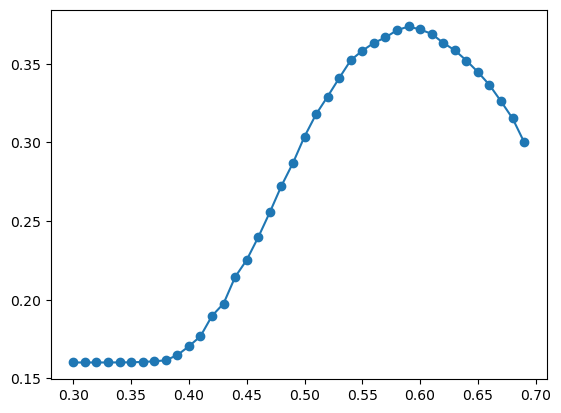

In [152]:
thr_l=np.arange(0.3,0.7,0.01)
f1_scores=[compute_scores(x_val_scaled,w_opt,y_val,threshold=t,apply_sigmoid=True)[2] for t in thr_l]
plt.plot(thr_l,f1_scores,marker='o')

In [159]:
np.save("w_log_reg_20f_fillnamean.npy",w_opt)

## Submission

In [25]:
x_train, x_test, y_train, train_ids, test_ids=load_csv_data("data")

In [40]:
x_test=pd.read_csv("data/x_test.csv")

In [160]:
x_test2=x_test.copy()
fill_mean=True
for col in intresting_features:
    x_test2[col].replace(dico_transfos[col],inplace=True)

        
    
if fill_mean:
    x_test_cleaned=x_test2[intresting_features].copy()
    for col in intresting_features:
        x_test_cleaned[col]=x_test_cleaned[col].fillna(x_tr_cleaned[col].mean())
else:
    x_test_cleaned=x_test2[intresting_features].fillna(0).copy()
x_test_scaled=(x_test_cleaned-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)

In [161]:
x_test_scaled.shape

(109379, 20)

In [163]:
predictions=make_predictions(x_test_scaled,w_opt,threshold=0.58,apply_sigmoid=True)

In [165]:
np.where(predictions==1)

(array([    14,     19,     22, ..., 109373, 109375, 109377], dtype=int64),)

In [166]:
predictions[np.where(predictions==0)[0]]=-1

In [167]:
predictions

array([-1, -1, -1, ..., -1,  1, -1])

In [168]:
create_csv_submission(test_ids,predictions,name="predictionslog20f_fillnamean.csv")